<a href="https://colab.research.google.com/github/Snrts/PRA3024_BigDataInPhysics_SanneAarts/blob/main/PRA3024W2ParticlePhysics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [610]:
# %pip install uproot awkward lz4 xxhash
# %pip install probfit
# %pip install iminuit
# %pip install matplotlib
# %pip install numpy==1.20
# %pip install pylorentz
# %pip install mpl-scatter-density

In [611]:
import uproot

import matplotlib.pyplot as plt
import mpl_scatter_density
import numpy as np
from scipy.stats import gaussian_kde

import iminuit
from iminuit import Minuit, cost
import probfit
from probfit.plotting import draw_normed_pdf
from probfit import gaussian, UnbinnedLH, BinnedLH

import pylorentz
from pylorentz import Momentum4

In [612]:
import matplotlib
matplotlib.rc('font', size=15)


## Opening the .root file

In [613]:
# from google.colab import drive
# drive.mount('/content/drive')

In [614]:
f = uproot.open("/content/drive/MyDrive/B2HHH_MagnetUp.root:DecayTree")
f.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
B_FlightDistance     | double                   | AsDtype('>f8')
B_VertexChi2         | double                   | AsDtype('>f8')
H1_PX                | double                   | AsDtype('>f8')
H1_PY                | double                   | AsDtype('>f8')
H1_PZ                | double                   | AsDtype('>f8')
H1_ProbK             | double                   | AsDtype('>f8')
H1_ProbPi            | double                   | AsDtype('>f8')
H1_Charge            | int32_t                  | AsDtype('>i4')
H1_IPChi2            | double                   | AsDtype('>f8')
H1_isMuon            | int32_t                  | AsDtype('>i4')
H2_PX                | double                   | AsDtype('>f8')
H2_PY                | double                   | AsDtype('>f8')
H2_PZ                | double                   | AsDtype(

## Calculations
### Total momentum of Daughters
For each of the daughter particles, the momentum four vector is given by:

\\
\begin{equation}
p^{\mu}=\left(\begin{array}{c}
      E\\
      p_x\\
      p_y\\
      p_z\\
      \end{array}\right)
\end{equation}

Where $$E=\sqrt{p^2+m^2}$$

\\
We take $m_1$, $m_2$, $m_3$ to be 493.677 $Mev/c^2$, the charged kaon mass as used in the Particle Listings

Citation: R.L. Workman et al. (Particle Data Group), Prog.Theor.Exp.Phys. 2022, 083C01 (2022)

In [615]:
#Calculating the four momentum of each daughter particle 
def energy(p,n):
    mass = 493.677 # mass of Kaon in MeV/c^2
    return np.sqrt(p**2+mass**2)

def FourMomentumDaughter(n):
    return Momentum4(energy(f.arrays(f"sqrt(H{n}_PX**2+H{n}_PY**2+H{n}_PZ**2)", library="np")[f"sqrt(H{n}_PX**2+H{n}_PY**2+H{n}_PZ**2)"],n),f.arrays(f"H{n}_PX", library="np")[f"H{n}_PX"],f.arrays(f"H{n}_PY", library="np")[f"H{n}_PY"],f.arrays(f"H{n}_PZ", library="np")[f"H{n}_PZ"])

#assigning the four momenta to the corrsponding particles
H1 = FourMomentumDaughter(1)
H2 = FourMomentumDaughter(2)
H3 = FourMomentumDaughter(3)

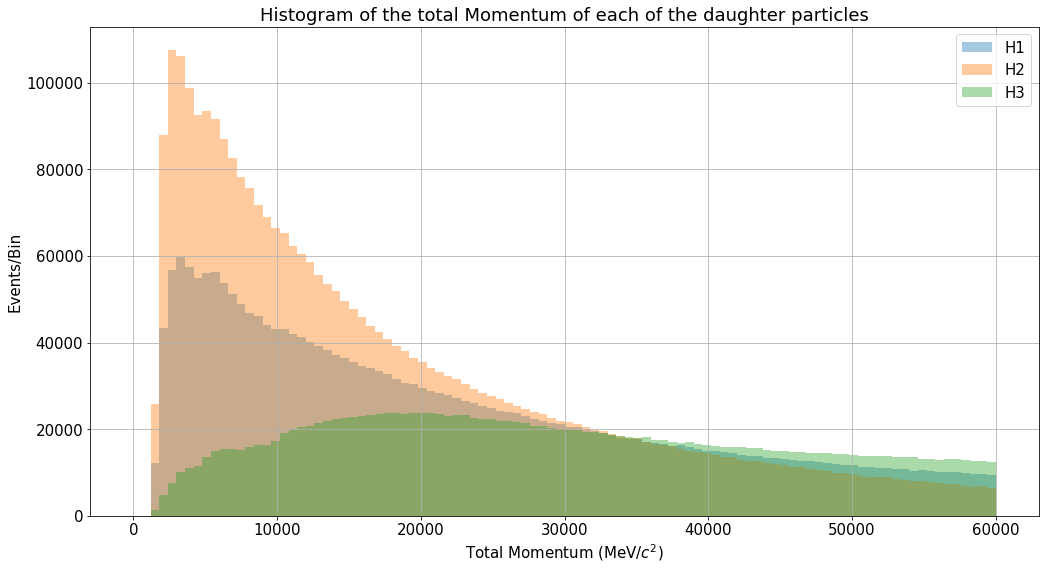

In [616]:
#Plotting the total momentum of each daughter particle and their frequency
# when we call .m on the four vector the total momentum is returned
fig = plt.figure(figsize=(17,9))
plt.hist(H1.p, bins= 100, alpha=0.4, range=[0, 60000],  label="H1")
plt.hist(H2.p, bins= 100, alpha=0.4, range=[0, 60000],  label="H2")
plt.hist(H3.p, bins= 100, alpha=0.4, range=[0, 60000],  label="H3")
plt.xlabel("Total Momentum (MeV/$c^2$)")
plt.ylabel("Events/Bin")
plt.title("Histogram of the total Momentum of each of the daughter particles")
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Total momentum of mother
The Four momentum of the mother particle is given by:

\\

$$p_m^{\mu}= p_1^{\mu}+p_2^{\mu}+p_3^{\mu}$$

\\

So We can just sum the four momenta of the daughter particles and from that request the momentum of the mother. This is equivalent to summing up the components of the momenta of the daughters and squaring them.

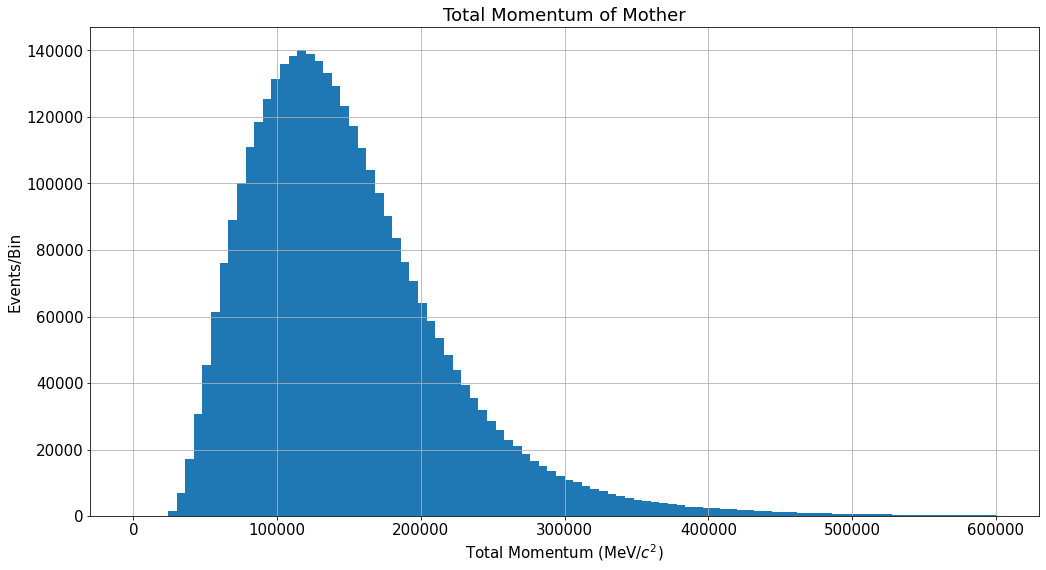

In [617]:
mother = H1+H2+H3
momentumMother = mother.p

plt.figure(figsize=(17,9))
plt.hist(momentumMother, bins= 100, range=[0, 600000])
plt.xlabel("Total Momentum (MeV/$c^2$)")
plt.ylabel("Events/Bin")
plt.title("Total Momentum of Mother")
plt.grid()
plt.show()

Alternative to the tree.show(45)

In [618]:
arr = f.arrays(library="np")
data = [f"{n} = {(arr[n])[45]}" for n in arr.keys()]
for d in data:
  print(d) 

B_FlightDistance = 4.714065519134621
B_VertexChi2 = 11.527835642103977
H1_PX = 133.37597488306847
H1_PY = -1293.522713059599
H1_PZ = 33534.216564227696
H1_ProbK = 0.007352352142333984
H1_ProbPi = 0.20490717887878418
H1_Charge = 1
H1_IPChi2 = 22.988488167413408
H1_isMuon = 0
H2_PX = 518.942836815797
H2_PY = -1966.1964311195359
H2_PZ = 52184.74396649723
H2_ProbK = 0.004820436239242554
H2_ProbPi = 0.26665544509887695
H2_Charge = -1
H2_IPChi2 = 20.56519869481346
H2_isMuon = 0
H3_PX = 1383.6240376483754
H3_PY = -2008.3497468201033
H3_PZ = 12153.955489049204
H3_ProbK = 0.08002465963363647
H3_ProbPi = 0.4037107229232788
H3_Charge = -1
H3_IPChi2 = 1584.9516601284706
H3_isMuon = 0


## Invariant mass of mother particle
For Four momentum 

$$p^{\mu}p_{\mu}=m^2 ⇔ m^2=E^2-p^2$$

but since we already constructed the four momentum of the mother, the pylorentz package returns the mass using:
```python
    mother.m
```


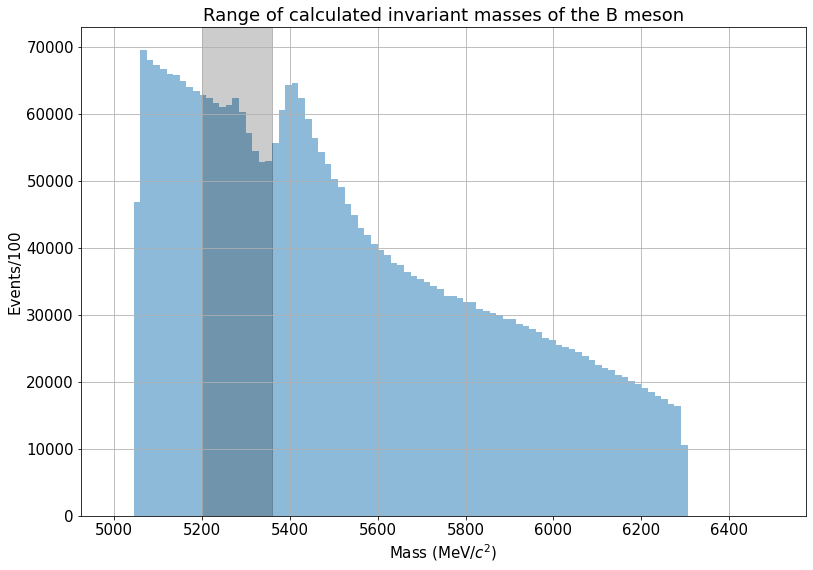

In [619]:
motherMass = mother.m
fig = plt.figure(figsize=(13,9))
plt.hist(motherMass, bins= 100, alpha=0.5, range=[5000,6500])
plt.xlabel("Mass (MeV/$c^2$)")
plt.ylabel("Events/100")
plt.title("Range of calculated invariant masses of the B meson")
plt.grid()
plt.axvspan(5200,5360, alpha=0.2, color="k") #highlight the area around the theoretical mass of the k+-
plt.show()

When calculating the invariant mass of the mother particle, we assumed that all of the daughter particles were Kaons and assumed all daughter particles therefore had the same mass (493.677$MeV/c^2$). They could however have been pions (139.57 $MeV/c^2$) or muons (105.66 $MeV/c^2$)

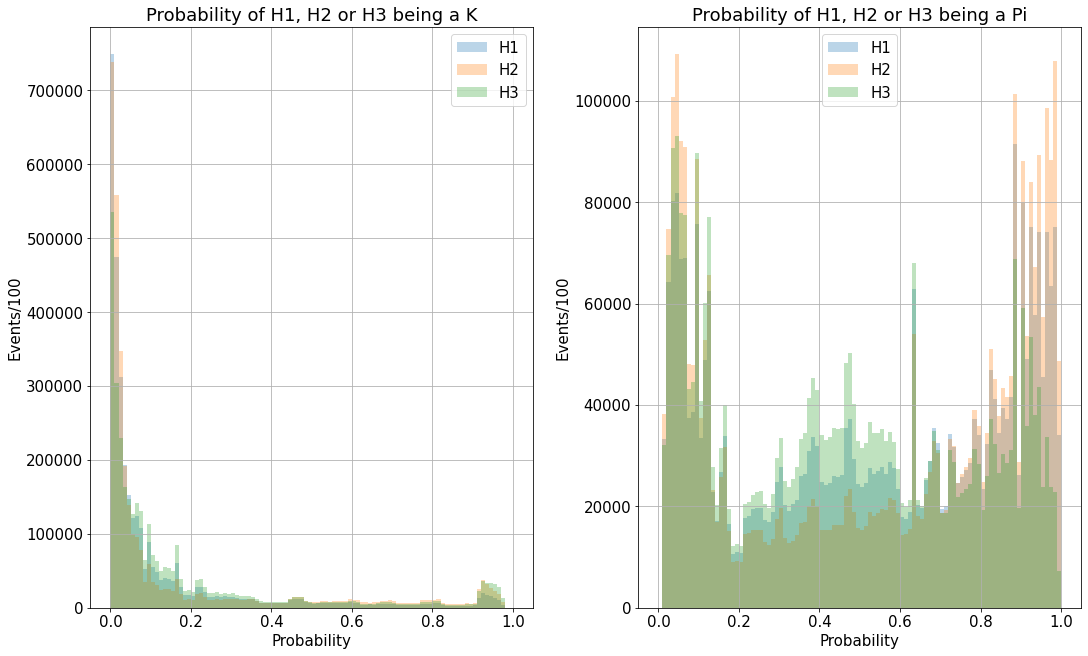

In [620]:
def probability(number, type):
    return f.arrays(f"H{number}_Prob{type}",library="np")[f'H{number}_Prob{type}']

def makeplots(type, fig):
    ax  = fig.subplots()
    ax.hist(probability(1, type), alpha=0.3, bins= 100, range=[0, 1], label="H1")
    ax.hist(probability(2, type), alpha=0.3, bins= 100, range=[0, 1], label="H2")
    ax.hist(probability(3, type), alpha=0.3, bins= 100, range=[0, 1], label="H3")
    ax.set_title(f"Probability of H1, H2 or H3 being a {type}")
    ax.set_ylabel("Events/100")
    ax.set_xlabel("Probability")
    ax.grid()
    ax.legend(loc="best")
    
fig = plt.figure(figsize=(15,9), constrained_layout=True)
subfigs = fig.subfigures(1,2, wspace=0.03)
makeplots("K", subfigs[0])
makeplots("Pi", subfigs[1])
plt.show()

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 8 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


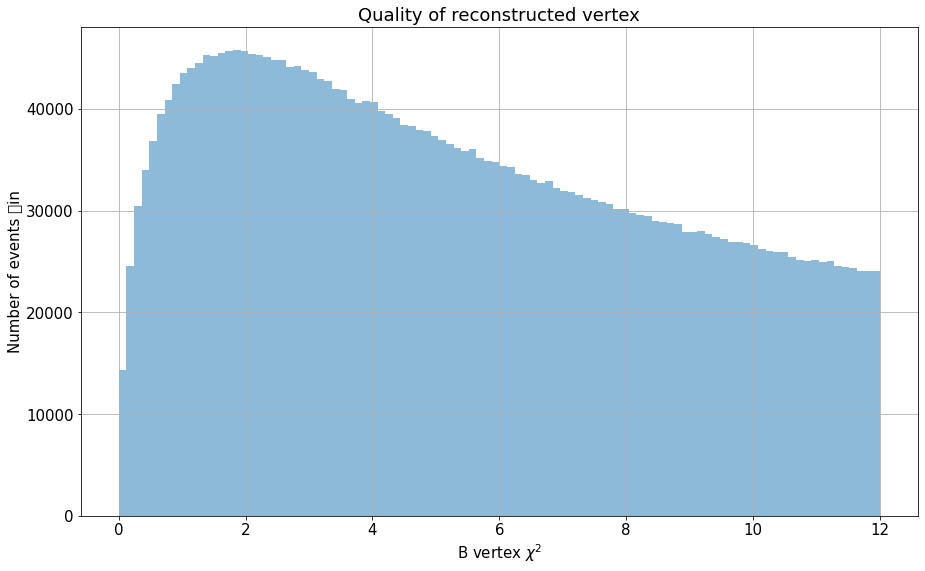

In [621]:
chi = f.arrays("B_VertexChi2", library="np")["B_VertexChi2"]
fig = plt.figure(figsize=(15,9))
plt.hist(chi, bins=100, alpha=0.5)
plt.grid()
plt.xlabel("B vertex $\chi^2$")
plt.ylabel("Number of events \bin")
plt.title("Quality of reconstructed vertex")
plt.show()

## Preselection

We already filter out all Muons and all events where the probability of one of the daughter particles being a kaon is less than 0.7 or the probability of them being a pion is higher than 0.7. It should be noted that the probabilities of the aformentioned do not add up to 1. Furthermore we cut out all the events where the daughter is a muon. 

After further research I decided to also exclude the events where the $\chi^2$ of the candidate was above 12 meaning that the track is unlikeli to come from the primary vertex. 

In [622]:
def filter(n):
    return f"(H{n}_ProbK>0.7)&(H{n}_ProbPi<0.7)&(H{n}_isMuon==0)"

filt = f"{filter(1)}&{filter(2)}&{filter(3)}&(B_VertexChi2<12)&((H1_IPChi2+H2_IPChi2+H3_IPChi2)>500)"
cut = f.arrays(cut=filt, library="np")


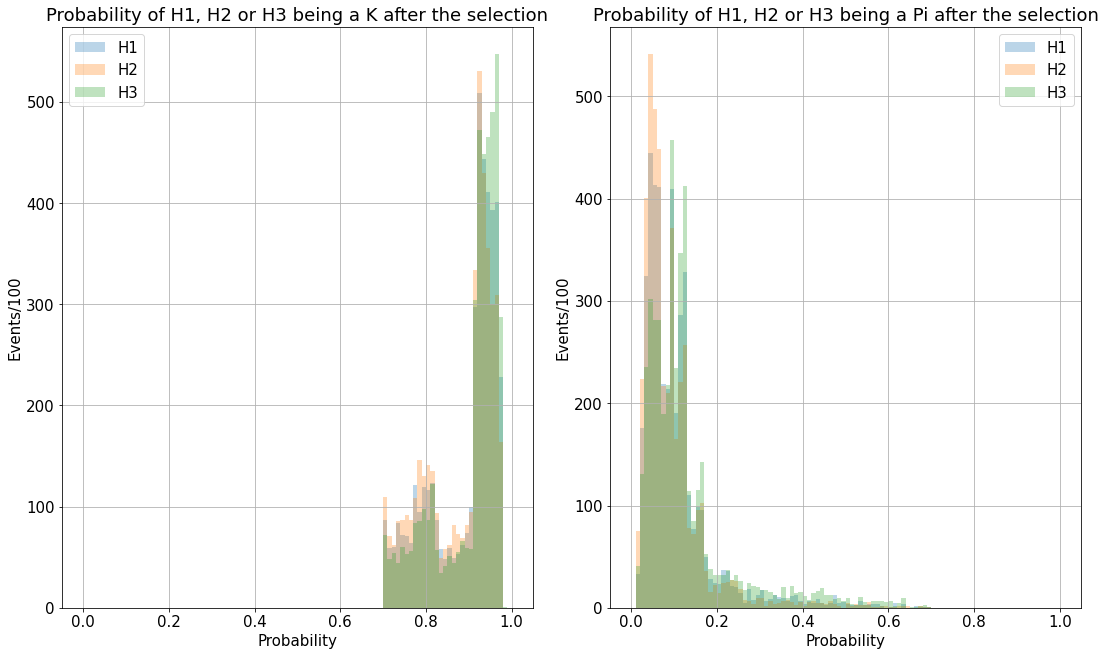

In [623]:
def makeplots(type, fig):
    ax  = fig.subplots()
    ax.hist(cut[f"H1_Prob{type}"], alpha=0.3, bins= 100, range=[0, 1], label="H1")
    ax.hist(cut[f"H2_Prob{type}"], alpha=0.3, bins= 100, range=[0, 1], label="H2")
    ax.hist(cut[f"H3_Prob{type}"], alpha=0.3, bins= 100, range=[0, 1], label="H3")
    ax.set_title(f"Probability of H1, H2 or H3 being a {type} after the selection")
    ax.set_ylabel("Events/100")
    ax.set_xlabel("Probability")
    ax.grid()
    ax.legend(loc="best")
    
fig = plt.figure(figsize=(15,9), constrained_layout=True)
subfigs = fig.subfigures(1,2, wspace=0.03)
makeplots("K", subfigs[0])
makeplots("Pi", subfigs[1])
plt.show()

## New calculation invariant mass

In [624]:
def MomentumDaughterCut(n):
    return Momentum4(energy(np.sqrt(cut[f"H{n}_PX"]**2+cut[f"H{n}_PY"]**2+cut[f"H{n}_PZ"]**2),n),cut[f"H{n}_PX"],cut[f"H{n}_PY"],cut[f"H{n}_PZ"])
  
H1Cut = MomentumDaughterCut(1)
H2Cut = MomentumDaughterCut(2)
H3Cut = MomentumDaughterCut(3)
motherCut = H1Cut+H2Cut+H3Cut

motherMassCut = motherCut.m

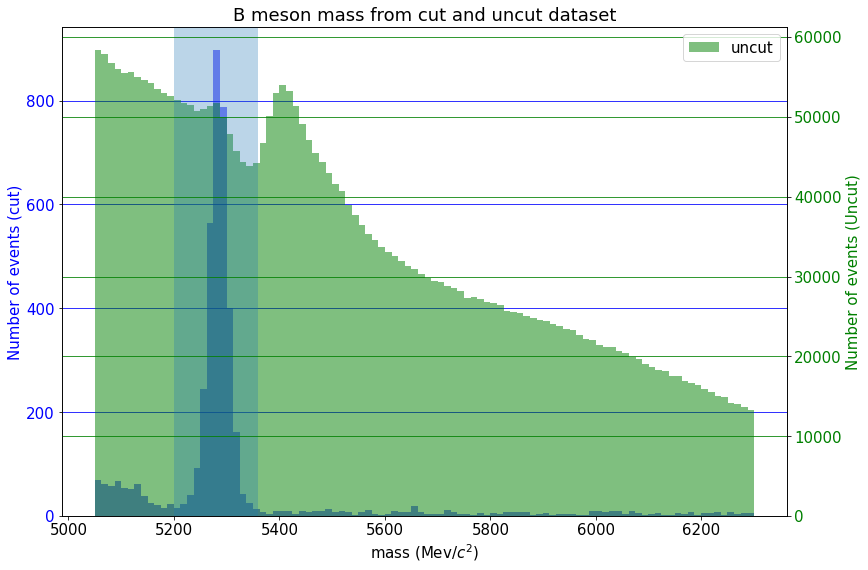

In [625]:
fig, ax1 = plt.subplots(figsize=(13,9))

ax1.set_xlabel('mass (Mev/$c^2$)')
ax1.set_ylabel('Number of events (cut)', color="b")
cut = ax1.hist(motherMassCut, bins=100, color="b", alpha=0.5, label="cut")
ax1.tick_params(axis='y', labelcolor="b")
ax1.grid(axis='y', color="b")

ax2 = ax1.twinx()  
ax2.set_ylabel('Number of events (Uncut)', color="g")
uncut = ax2.hist(motherMass, bins=100, color="g", alpha=0.5, label="uncut", )
ax2.tick_params(axis='y', labelcolor="g")

ax2.grid(axis='y', color="g", which='both')
plt.title("B meson mass from cut and uncut dataset")
interval = ax2.axvspan(5200,5360, alpha=0.3, label="")
plt.legend()
plt.show()

## Fitting the Data

Using a combination of th iminuit and probfit packages to minimize the errors

In [626]:
def fitData(type): #this function bins the data such that we can use a binned cost function
  frequency, binedges= np.histogram(type, bins=100)
  mass = (binedges[1:]+binedges[:-1])/2 # ensures that the value of the mass that is returned is the middle of the mass bin
  return mass, frequency

def fetchfuncName(func):
  for name in dict(globals()):
    if dict(globals())[name] is func:
      return str(name)

def fit( fig,type, params, sig, bg):
  global gaussian, crystalBall, exponential
  label = fetchfuncName(sig)
  fit_range = (min(fitData(type)[0]), max(fitData(type)[0]))
  gaussian = probfit.Extended(probfit.gaussian,extname='NSig') #Extended fits take into account the amplitude, the gaussian is our signal
  crystalBall = probfit.Extended(probfit.Normalized(probfit.crystalball, bound=fit_range), extname='NSig')
  exponential = probfit.Extended(probfit.Normalized(probfit.exponential, bound=fit_range), extname='NBkg') #the exponential our background
  pdf = probfit.AddPdf(sig, bg) # combines the two into a fit model
  probfit.describe(pdf)
  likelihood=probfit.BinnedLH(pdf, type, bins=100, bound=fit_range, extended = True);
  m=Minuit(likelihood, print_level=0, **params, pedantic=False);
  try: 
    m.migrad(); 
    try:
        m.hesse();
        try:
          m.minos();
        except:
          print("Fitiing was not Completed")
    except:
        print("Fitiing was not Completed")
  except:
    print("Fitiing was not Completed")
  finally:
    print(m.valid)
    print(m.accurate)
  (ax1,ax2)  = fig.subplots(nrows=2,ncols=1, squeeze=True, gridspec_kw={'height_ratios':[5,1]})

  ax1.scatter(fitData(type)[0],fitData(type)[1], c='k', alpha=0.5, label ="data")
  _,a=probfit.plotting.draw_pdf(pdf,arg=m.values.values(),density=False, bound=fit_range, bins=100, label= "full model", lw=3, color='r', ax=ax1)
  _,b=probfit.plotting.draw_pdf(sig,arg={p:m.values[p] for p in m.values if p in probfit.describe(sig)}, density=False, bound=fit_range, bins=100,label=f"{label}", ls="--", color="b", lw=3, ax=ax1)
  _,c=probfit.plotting.draw_pdf(bg,arg={p:m.values[p] for p in m.values if p in probfit.describe(bg)}, density=False, bound=fit_range, bins=100, label="Ëxponential", ls="--", color="g", lw=3, ax=ax1)
  ax1.fill_between(fitData(type)[0][0:99],a,y2=0, alpha=0.2, color="r")
  ax1.fill_between(fitData(type)[0][0:99],b,y2=0, alpha=0.2, color="b")
  ax1.fill_between(fitData(type)[0][0:99],c,y2=0, alpha=0.2, color="g")
  try: 
    chi2 = m.fval #
    n_dof=len(fitData(type)[0])-m.nfit
    fit_data = [f"$\\chi^2$ / $n_{{dof}}$ = {round(chi2 / n_dof, 4)}"]  
  except:
    fit_data = [] 
  for parameter, value, error in zip(m.parameters, m.values.values(), m.errors.values()):
      fit_data.append(f"{parameter} = ${round(value,3)} \\pm  {round(error,3)}$")
  ax1.set_title(f"Fit of {label} over Exponential background for {fetchfuncName(type)}")
  ax1.set_xlabel("Invariant Mass Mev/$c^2$")
  ax1.set_ylabel("Events / 100")
  ax1.legend(title="\n".join(fit_data))
  ax1.grid()
  likelihood.draw_residual(m, ax=ax2, grid=False, zero_line=False,show_errbars=True, fmt="ok")
  ax2.set_ylim((-50,50))
  ax2.set_ylabel("residuals")
      

  return {"N": m.values['NSig'],"error": m.errors["NSig"],"chi2/ndof": round(chi2/n_dof, 4)}

<ipython-input-626-e3fe84d81b52>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pdf = probfit.AddPdf(sig, bg) # combines the two into a fit model
<ipython-input-628-64fd1cb418b0>:7: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  gaussFit =fit(subfigs[0], motherMassCut, p_gauss, gaussian, exponential);


True
True


<ipython-input-628-64fd1cb418b0>:8: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  crystalFit=fit(subfigs[1], motherMassCut, p_crystl, crystalBall, exponential);
<ipython-input-626-e3fe84d81b52>:23: SmallIntegralWarning: (5.0, 0.9997150083652193, 5285.0, 49.999952316299336)
  m.migrad();
<ipython-input-626-e3fe84d81b52>:27: SmallIntegralWarning: (0.8086655626626262,)
  m.minos();


Fitiing was not Completed
True
True


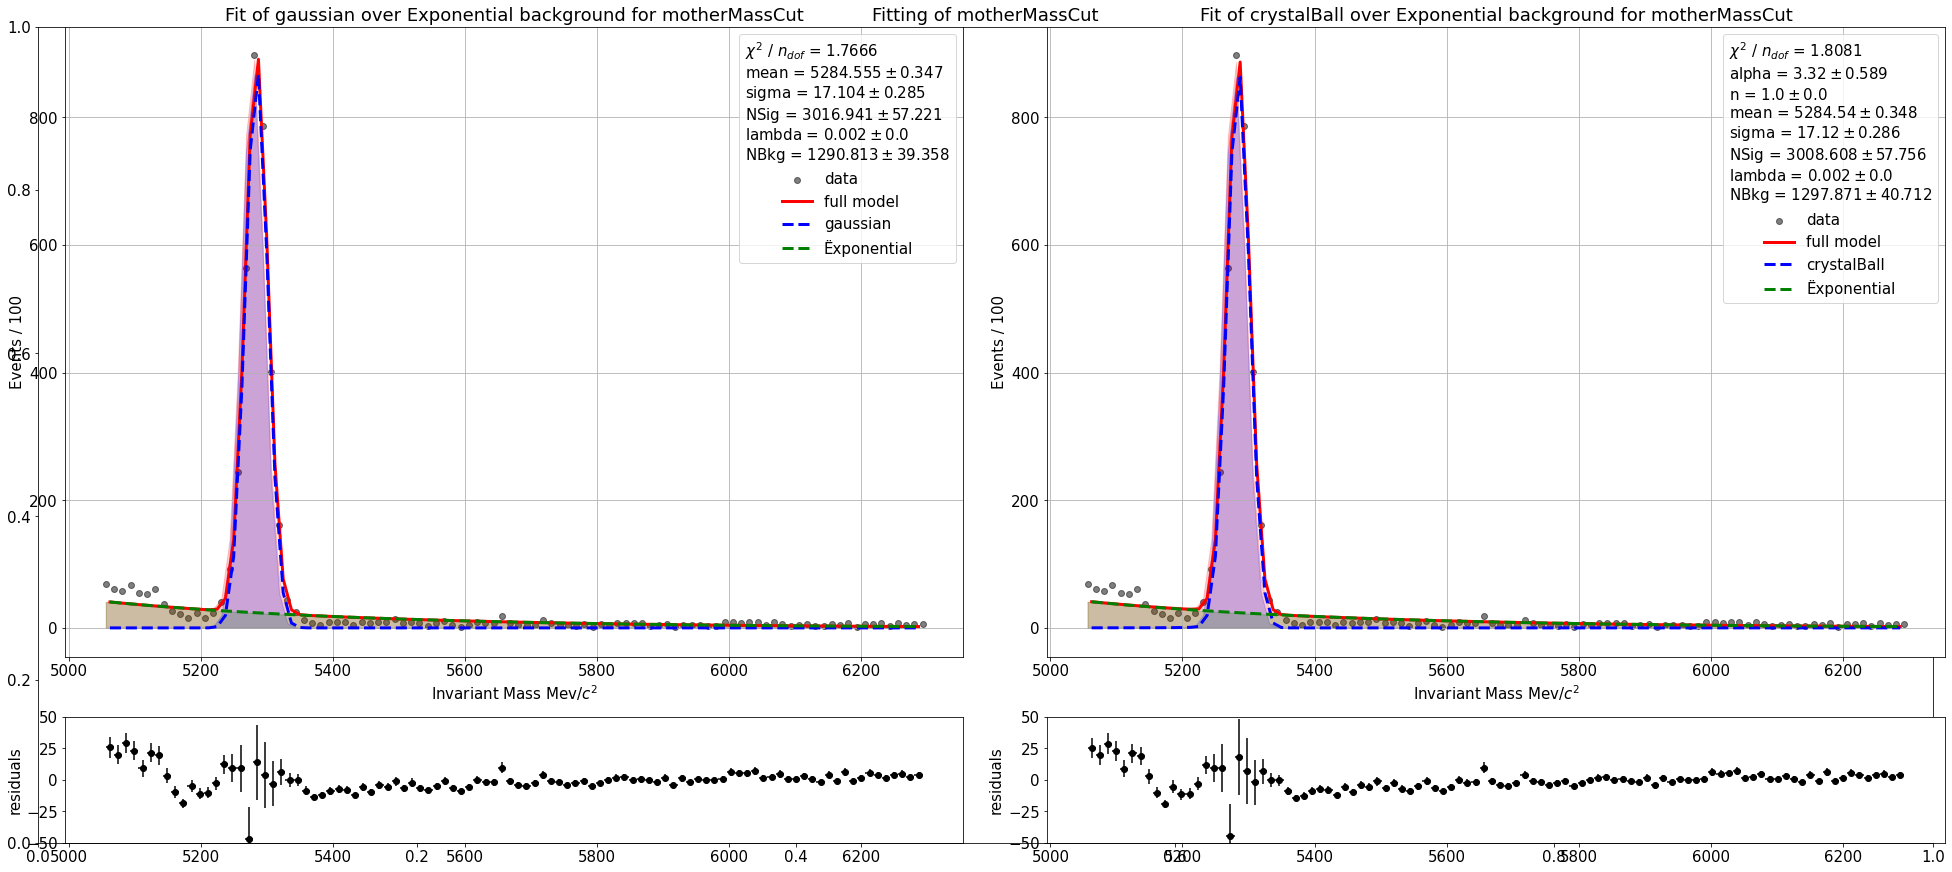

In [628]:
p_gauss = {'mean': 5280, 'limit_mean':(5000,5550), 'sigma': 17, "limit_sigma":(0,50), 'NSig':3000, 'limit_NSig':(500,len(motherMassCut)),'NBkg':1300, 'limit_NBkg':(0,len(motherMassCut)), 'lambda':0.003, 'limit_lambda':(0,2)}
p_crystl = {'alpha':5,'limit_alpha': (0.1,10),'n':1,'limit_n':(0.1,10),'mean': 5285, 'limit_mean':(5000,5550), 'sigma': np.std(motherMassCut), "limit_sigma":(0,50), 'NSig':3020, 'limit_NSig':(500,len(motherMassCut)),'NBkg':1260, 'limit_NBkg':(0,len(motherMassCut)), 'lambda':0.003, 'limit_lambda':(0,2)}

fig = plt.figure(constrained_layout=True, figsize=(27, 12))
plt.title("Fitting of motherMassCut")
subfigs = fig.subfigures(1,2)
gaussFit =fit(subfigs[0], motherMassCut, p_gauss, gaussian, exponential);
crystalFit=fit(subfigs[1], motherMassCut, p_crystl, crystalBall, exponential);


## Counting

We create two new arrays "Minus" and "Plus", the former is a subset of the original tree where the charges of the daughters add up to -1 (corresponding to two negative charges and 1 positive charge) and the latter is a subset of the original tree where the charges of the daughters add up to +1 (corresponding to two positive charges and one negative charge)

In [629]:
def childrenCharge():
    return "H1_Charge+H2_Charge+H3_Charge"

condition =  f"{filter(1)}&{filter(2)}&{filter(3)}&(B_VertexChi2<12)&((H1_IPChi2+H2_IPChi2+H3_IPChi2)>500)"# refers to the function earlier in the notebook used to filter the tree where we required that the
                                                   # probability of a muon was 0 and the probability of the daughter being a Kaon was bigger than 0.8
Minus = f.arrays(cut=f"({childrenCharge()}==-1)&{condition}", library="np") # we require that both the charge condition and the previous conditions hols
Plus = f.arrays(cut=f"({childrenCharge()}==1)&{condition}", library="np")

In [630]:
def  MomentumDaughterCut2(type, n):
     return Momentum4(energy(np.sqrt(type[f"H{n}_PX"]**2+type[f"H{n}_PY"]**2+type[f"H{n}_PZ"]**2),n), type[f"H{n}_PX"],type[f"H{n}_PY"],type[f"H{n}_PZ"])

MinusFour = MomentumDaughterCut2(Minus,1)+MomentumDaughterCut2(Minus,2)+MomentumDaughterCut2(Minus,3)
PlusFour= MomentumDaughterCut2(Plus,1)+MomentumDaughterCut2(Plus,2)+MomentumDaughterCut2(Plus,3)
mMinus = MinusFour.m
mPlus = PlusFour.m

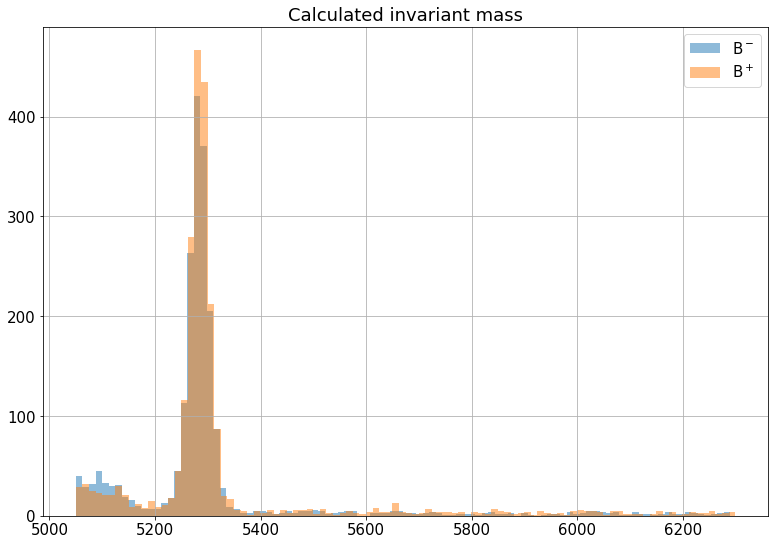

In [631]:
fig = plt.figure(figsize=(13,9))
plt.hist(mMinus, bins=100, alpha=0.5, label="B$^-$")
plt.hist(mPlus, bins=100, alpha=0.5, label="B$^+$")
plt.title("Calculated invariant mass")
plt.grid()
plt.legend()

<ipython-input-626-e3fe84d81b52>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pdf = probfit.AddPdf(sig, bg) # combines the two into a fit model
<ipython-input-632-454e27cc0127>:6: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  NMinusg=fit(subfigs[0] ,mMinus, p_min, gaussian, exponential)
<ipython-input-626-e3fe84d81b52>:23: LogWarning: x is really small return 0
  m.migrad();
<ipython-input-626-e3fe84d81b52>:25: LogWarning: x is really small return 0
  m.hesse();
<ipython-input-626-e3fe84d81b52>:27: LogW

True
True


<ipython-input-632-454e27cc0127>:7: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  NPlusg=fit(subfigs[1],mPlus, p_plus, gaussian, exponential)


True
True


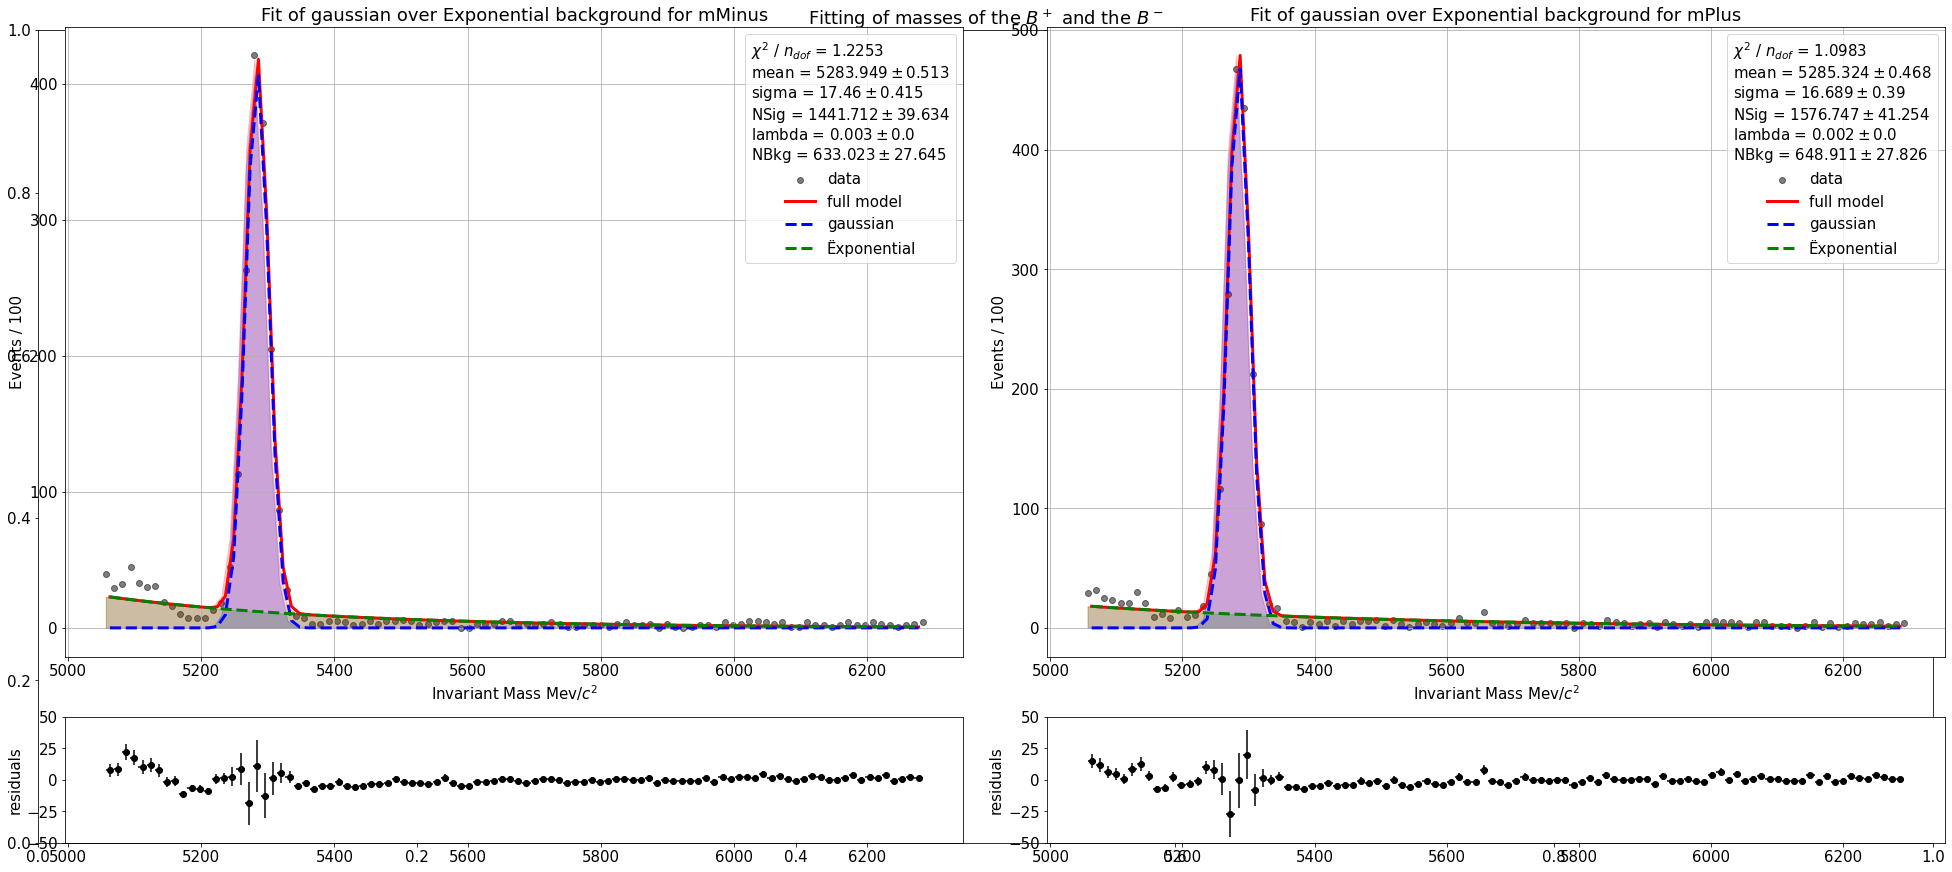

In [632]:
fig = plt.figure(constrained_layout=True, figsize=(27, 12))
plt.title("Fitting of masses of the $B^+$ and the $B^-$")
subfigs = fig.subfigures(1,2)
p_min = {'mean': 5280, 'limit_mean':(5000,5550), 'sigma': 17, "limit_sigma":(0,50), 'NSig':1400, 'limit_NSig':(500,len(mMinus)),'NBkg':600, 'limit_NBkg':(0,len(mMinus)), 'lambda':0.003, 'limit_lambda':(0,2)}
p_plus =  {'mean': 5280, 'limit_mean':(5000,5550), 'sigma': 17, "limit_sigma":(0,50), 'NSig':1550, 'limit_NSig':(500,len(mPlus)),'NBkg':630, 'limit_NBkg':(0,len(mPlus)), 'lambda':0.003, 'limit_lambda':(0,2)}
NMinusg=fit(subfigs[0] ,mMinus, p_min, gaussian, exponential)
NPlusg=fit(subfigs[1],mPlus, p_plus, gaussian, exponential)

<ipython-input-626-e3fe84d81b52>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pdf = probfit.AddPdf(sig, bg) # combines the two into a fit model
<ipython-input-633-5f71d4adf034>:6: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  NMinusc=fit(subfigs[0] ,mMinus, p_minc, crystalBall, exponential)
<ipython-input-626-e3fe84d81b52>:23: LogWarning: x is really small return 0
  m.migrad();
<ipython-input-626-e3fe84d81b52>:23: SmallIntegralWarning: (2.5000000000000004, 0.9999000010442535, 5280.0, 17.0)
  m.migrad()

Fitiing was not Completed
True
True


<ipython-input-633-5f71d4adf034>:7: DeprecationWarning: Using .default_errordef() is deprecated. Use .errordef instead
  NPlusc=fit(subfigs[1],mPlus, p_plusc, crystalBall, exponential)
<ipython-input-626-e3fe84d81b52>:27: SmallIntegralWarning: (1.7201585116086158,)
  m.minos();


Fitiing was not Completed
True
True


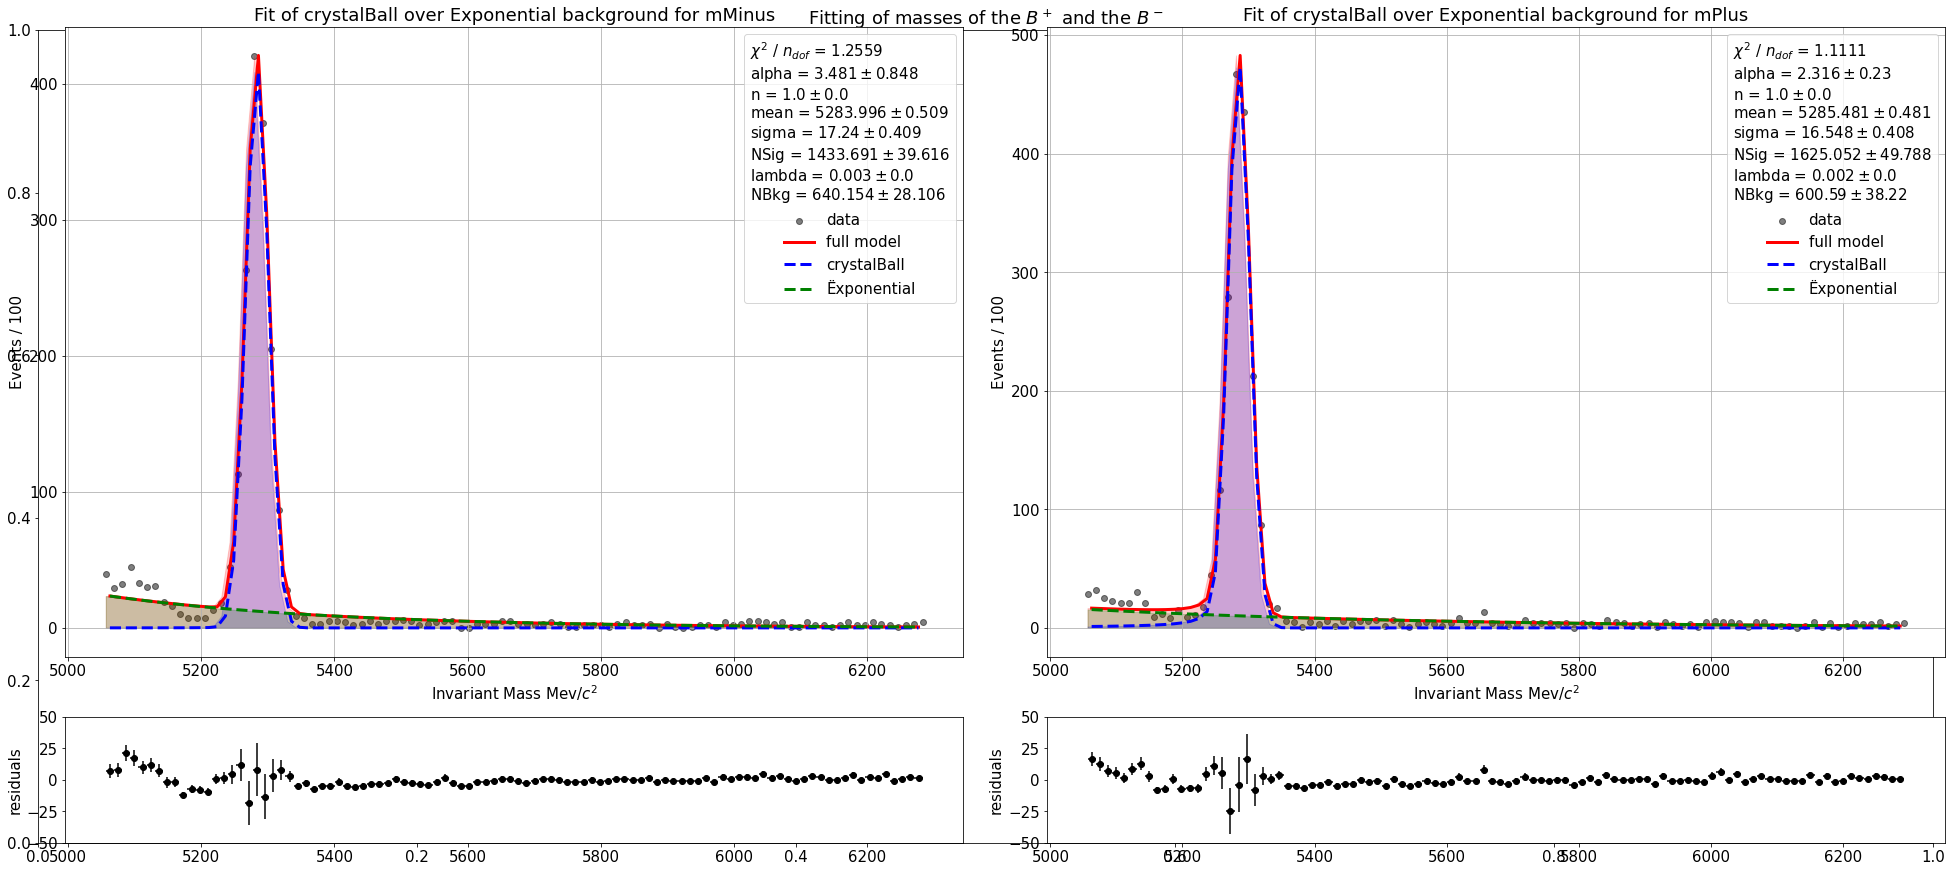

In [633]:
fig = plt.figure(constrained_layout=True, figsize=(27, 12))
plt.title("Fitting of masses of the $B^+$ and the $B^-$")
subfigs = fig.subfigures(1,2)
p_minc = {'alpha':2.5,'limit_alpha': (0.1,10),'n':1,'limit_n':(0.1,10), 'mean': 5280, 'limit_mean':(5000,5550), 'sigma': 17, "limit_sigma":(0,50), 'NSig':1420, 'limit_NSig':(500,len(mMinus)),'NBkg':600, 'limit_NBkg':(0,len(mMinus)), 'lambda':0.003, 'limit_lambda':(0,2)}
p_plusc = {'alpha':2.5,'limit_alpha': (0.1,10),'n':1,'limit_n':(0.1,10),'mean': 5280, 'limit_mean':(5000,5550), 'sigma': 17, "limit_sigma":(0,50), 'NSig':1550, 'limit_NSig':(500,len(mPlus)),'NBkg':600, 'limit_NBkg':(0,len(mPlus)), 'lambda':0.003, 'limit_lambda':(0,2)}
NMinusc=fit(subfigs[0] ,mMinus, p_minc, crystalBall, exponential)
NPlusc=fit(subfigs[1],mPlus, p_plusc, crystalBall, exponential)

In [634]:
NPlus = (NPlusc['N']+NPlusg["N"])/2
NMinus = (NMinusc['N']+NMinusg["N"])/2

def asymmetry(Nplus, Nminus):
    return (Nminus-Nplus)/(Nminus+Nplus)

def deviation(Nplus, Nminus):
    return np.sqrt((1-asymmetry(Nplus, Nminus)**2)/(Nminus+Nplus))

asym=asymmetry(NPlus, NMinus)
dev=deviation(NPlus, NMinus)

print("assymetry =", asym, "deviation =", dev)


assymetry = -0.05370821387052472 deviation = 0.01811489619296256


In [635]:
Plus.update({k:Plus[k][range(len(Minus["H1_PX"]))] for k in Plus.keys()})

h1 = MomentumDaughterCut2(Plus,1)
h2 = MomentumDaughterCut2(Plus,2)
h3 = MomentumDaughterCut2(Minus,3)

s_12 = ((h1+h2).m2)/1000000
s_13 = ((h1+h3).m2)/1000000
s_23 = ((h2+h3).m2)/1000000


In [636]:
def density(fig, x, y):
  ax = fig.subplots()
  ax.grid()
  ax.set_xticks(np.linspace(0,250, 10))
  ax.set_yticks(np.linspace(0,250, 10))
  xy=np.vstack([x,y])
  z =  gaussian_kde(xy)(xy)
  density = ax.scatter(x,y, s=5,c=z, cmap="hsv")
  
  fig.colorbar(density, label="Events\Bin")

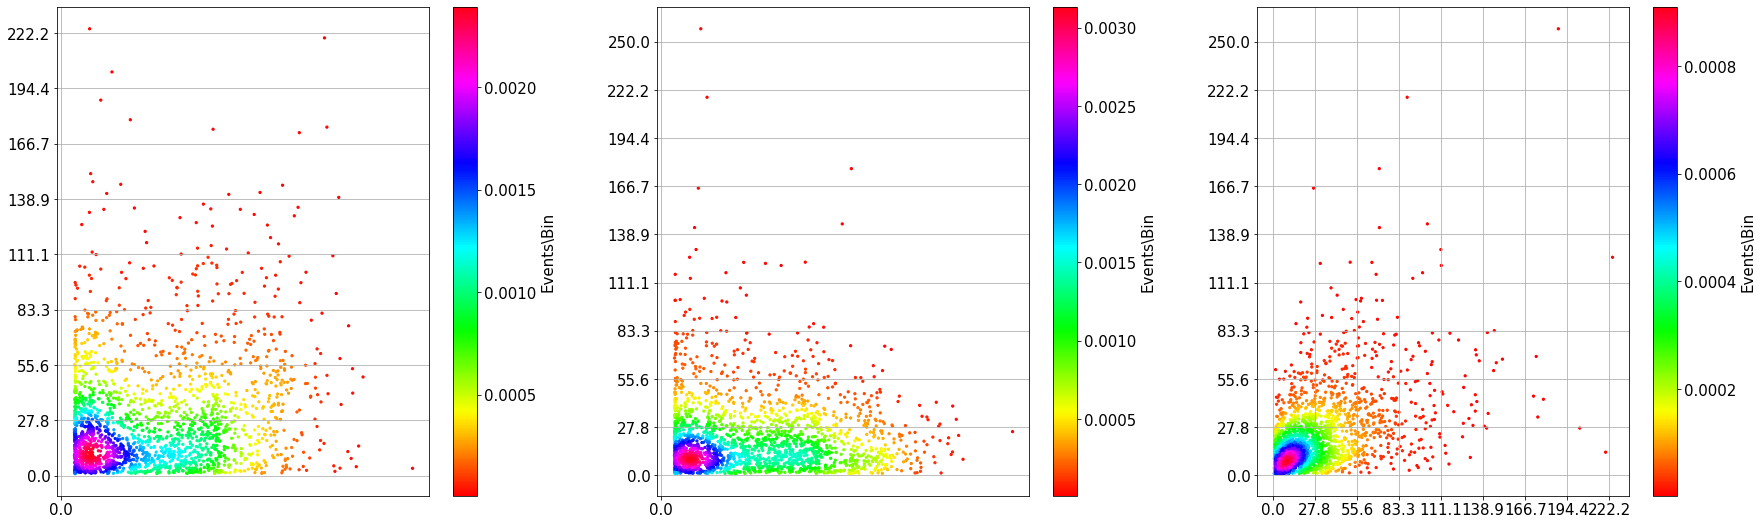

In [637]:
fig=plt.figure(figsize=(25,9))
subfigs = fig.subfigures(1,3)
density(subfigs[0], s_12, s_13)
density(subfigs[1], s_12, s_23)
density(subfigs[2], s_13, s_23)
plt.show()